In [59]:
import numpy as np
import matplotlib.pyplot as plt
import copy

X_train shape: (2, 400)
X_test shape: (2, 100)
y_train shape: (1, 400)
y_test shape: (1, 100)


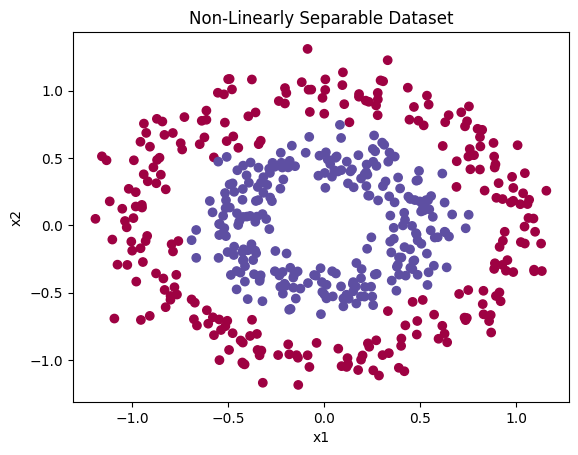

In [60]:
# Helper function to generate the dataset
def generate_nonlinear_dataset(n_samples=500, noise=0.1):
    """
    Generates a dataset with two classes that are not linearly separable.
    
    Parameters:
        n_samples (int): Number of samples per class.
        noise (float): Amount of Gaussian noise added to the data.
        
    Returns:
        X (np.ndarray): Input features of shape (n_samples * 2, 2).
        Y (np.ndarray): Labels of shape (n_samples * 2, 1).
    """
    from sklearn.datasets import make_circles
    
    # Generate two concentric circles
    np.random.seed(42)  # For reproducibility
    X, Y = make_circles(n_samples=n_samples, factor=0.5, noise=noise)
    
    # Reshape labels to column vector
    Y = Y.reshape(-1, 1)
    
    return X, Y

# Generate the dataset
X, Y = generate_nonlinear_dataset(n_samples=500, noise=0.1)
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Transpose X_train and y_train to match the desired shape (n, m)
X_train = X_train.T  # Shape becomes (2, m)
y_train = y_train.T  # Shape becomes (1, m)

# Similarly, transpose X_test and y_test
X_test = X_test.T  # Shape becomes (2, m_test)
y_test = y_test.T  # Shape becomes (1, m_test)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=Y.ravel(), cmap=plt.cm.Spectral)
plt.title("Non-Linearly Separable Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [61]:
## A the main logic functions of the model
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    # The pre-activation function
    Z = np.dot(W,A) + b
    # As in the describtion, it is for the backword propagation
    cache = (A, W, b)
    
    return Z, cache
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/ (1+np.exp(-z))
    return s,z
def relu(z):
    """
    Compute the relu of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- relu(z)
    """

    s = np.maximum(0, z)
    return s,z
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache
def L_model_forward(X, parameters):

    """
    Implement forward propagation for the [LINEAR->RELU] for the first (L-1) layers->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2        # number of layers in the neural network

    #[LINEAR -> RELU] for the first (L-1) layers. 

    # The for loop starts at 1 because layer 0 is the input.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
        
    
    # LINEAR -> SIGMOID.
    AL, cache = A, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    return AL, caches
def compute_cost(AL, Y):
    """
    Implement the cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (ex: 0 for PNEUMONIA, 1 for NORMAL), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = -(np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))) / m
    
    
    cost = np.squeeze(cost)     # To make sure your cost's shape is what we expect 
                                # (e.g. this turns [[17]] into 17).

    return cost
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True) # Sum by rows
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db
def relu_backward(dA, activation_cache):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    activation_cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)  # Just converting dz to a correct object.
    
    # When Z <= 0, set dZ to 0 (derivative of ReLU is 0 for Z <= 0)
    dZ[Z <= 0] = 0
    
    return dZ
def sigmoid_backward(dA, activation_cache):
    """
    Implement the backward propagation for a single Sigmoid unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    activation_cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = activation_cache
    
    # Compute the Sigmoid value (A) from Z
    A = 1 / (1 + np.exp(-Z))
    
    # Compute the derivative of the Sigmoid function
    dZ = dA * A * (1 - A)
    
    return dZ    
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db= linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db= linear_backward(dZ, linear_cache)
        
    
    return dA_prev, dW, db
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 for PNEUMONIA, 1 for NORMAL)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers

    Y = Y.reshape(AL.shape[0],AL.shape[1]) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Last layer (SIGMOID -> LINEAR) gradients.
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp     
        
    return grads
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]        
        
    return parameters
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary of a model.
    
    Parameters:
        model (function): Prediction function.
        X (np.ndarray): Input data.
        y (np.ndarray): True labels.
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.02  # Step size in the mesh
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary")
def predict(X, y, parameters):
    """
    Predict labels for input data using the trained model.
    
    Arguments:
    X -- input data (n_features, m), where m is the number of examples
    y -- true labels (1, m), not used in prediction but included for compatibility
    parameters -- dictionary containing trained parameters
    
    Returns:
    predictions -- binary predictions (0 or 1) of shape (1, m)
    """
    # Forward propagation through the entire network
    AL, _ = L_model_forward(X, parameters)  # X is already in (n_features, m) format
    
    # Convert probabilities to binary predictions (>=0.5 becomes 1, else 0)
    predictions = (AL >= 0.5).astype(int)
    
    # Calculate accuracy by comparing predictions with true labels
    accuracy = np.mean(predictions == y) * 100  # Percentage of correct predictions
    
    return accuracy

In [62]:
# Here we made W and b both zeros
def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [63]:
def initialize_parameters_random(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as ours
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))

    return parameters

In [64]:
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] =  np.random.randn(layers_dims[l],layers_dims[l-1]) * (np.sqrt(2./layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        
        
    return parameters

In [65]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0],10, 5, 1]
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = L_model_forward(X, parameters)

        # Loss
        cost = compute_cost(a3, Y)

        # Backward propagation.
        grads = L_model_backward(a3, Y, cache)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### First, we will start with initializing the W to zeros:

Cost after iteration 0: 0.6931471805599452
Cost after iteration 1000: 0.692538672911241
Cost after iteration 2000: 0.6925345831797515
Cost after iteration 3000: 0.692534555633385
Cost after iteration 4000: 0.6925345554478048
Cost after iteration 5000: 0.6925345554465548
Cost after iteration 6000: 0.6925345554465462
Cost after iteration 7000: 0.6925345554465462
Cost after iteration 8000: 0.6925345554465462
Cost after iteration 9000: 0.6925345554465462
Cost after iteration 10000: 0.6925345554465463
Cost after iteration 11000: 0.6925345554465462
Cost after iteration 12000: 0.6925345554465463
Cost after iteration 13000: 0.6925345554465462
Cost after iteration 14000: 0.6925345554465462


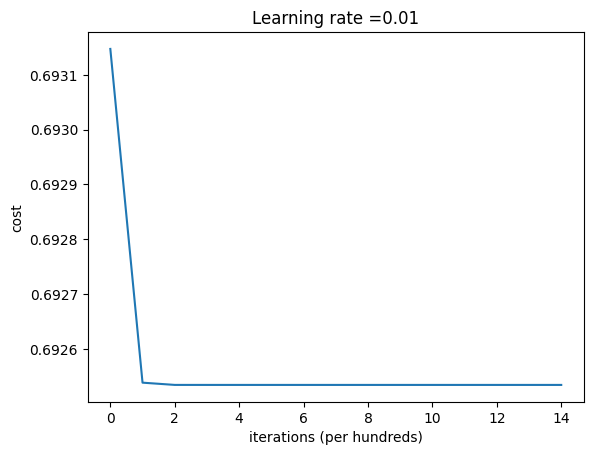

On the train set:
51.74999999999999
On the test set:
43.0


In [66]:
parameters = model(X_train, y_train, initialization = "zeros")
print ("On the train set:")
predictions_train = print(predict(X_train, y_train, parameters))
print ("On the test set:")
predictions_test = print(predict(X_test, y_test, parameters))

### 📉 Observations from Zero Initialization

As we can see from the cost graph and the predictions on both the training and test sets:

- The model **predicts the same constant value for all inputs**, resulting in all zeros.
- This happens because **when the weights `W` are initialized to zeros**, the computation of the linear component:

  \[
  Z = W . X + b
  \]

  always results in the same scalar value (`b`, since `W` is zero), regardless of the input `X`.

- Feeding a constant `Z` into an activation function like `sigmoid` or `tanh` leads to a **constant output**:

  \[
  sigma(Z) = sigma(0) = 0.5 or tanh(0) = 0
  \]

- When using a **threshold** to convert the activation output to class predictions (e.g., `sigmoid(Z) > 0.5 → 1`, else `0`), we end up **always predicting the same class**.

- As a result, **the cost remains unchanged** across all training iterations because the model is unable to learn or adjust its predictions.

> 🔁 This demonstrates why **initializing weights to zero is a bad idea** — it leads to **no symmetry breaking**, and thus the model cannot learn.


Cost after iteration 0: 2.1219368293786136
Cost after iteration 1000: 0.43615261340152073
Cost after iteration 2000: 0.22074247731058624
Cost after iteration 3000: 0.13715576479264568
Cost after iteration 4000: 0.09957643515393567
Cost after iteration 5000: 0.07908320036453247
Cost after iteration 6000: 0.06571331805467046
Cost after iteration 7000: 0.056187250102634374
Cost after iteration 8000: 0.04902750266880216
Cost after iteration 9000: 0.043530819357784446
Cost after iteration 10000: 0.03936909513109095
Cost after iteration 11000: 0.03605423652297542
Cost after iteration 12000: 0.03336166537093124
Cost after iteration 13000: 0.031121850195956847
Cost after iteration 14000: 0.02923253029970301


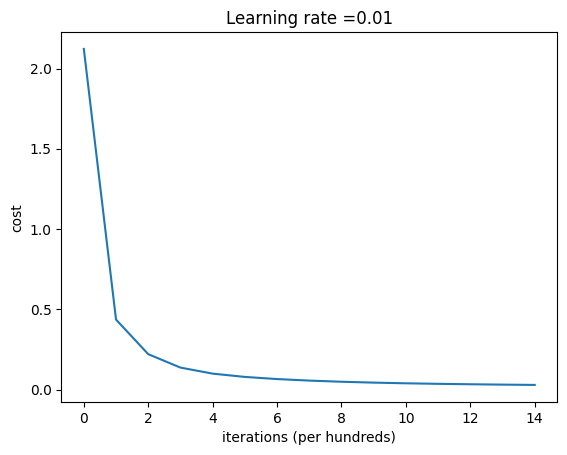

On the train set:
99.5
On the test set:
99.0


In [67]:
## Now with random ( high W value )
parameters = model(X_train, y_train, initialization = "random")
print ("On the train set:")
predictions_train = print(predict(X_train, y_train, parameters))
print ("On the test set:")
predictions_test = print(predict(X_test, y_test, parameters))

### 📉 Observations from Random initialization.

 The `cost` in the first iteration was (2.12 !!), thats so high. so we could handel that by 2 ways:
- one is by decreasing the W, we could multiply it by: 0.01 or 0.02
- the second is to use theoritical initialization like `Xavier` or `He` initializations

### 6 - He Initialization :

Finally, `"He Initialization"`; this is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)

we will multiply by this term : $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$

Cost after iteration 0: 0.9555065856906311
Cost after iteration 1000: 0.5792765870138408
Cost after iteration 2000: 0.3237446696529244
Cost after iteration 3000: 0.18190923747307558
Cost after iteration 4000: 0.12003097320503243
Cost after iteration 5000: 0.08776934768283272
Cost after iteration 6000: 0.06862458698582825
Cost after iteration 7000: 0.05599830331870778
Cost after iteration 8000: 0.046937490922523056
Cost after iteration 9000: 0.04077073126916657
Cost after iteration 10000: 0.03613757259418711
Cost after iteration 11000: 0.03269756559874392
Cost after iteration 12000: 0.029990126688774446
Cost after iteration 13000: 0.027789222285952375
Cost after iteration 14000: 0.02592498975592756


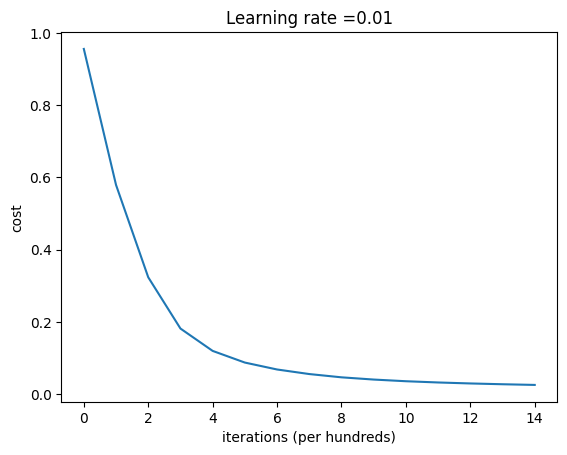

On the train set:
99.5
On the test set:
100.0


In [68]:
## finally he initialization 
parameters = model(X_train, y_train, initialization = "he")
print ("On the train set:")
predictions_train = print(predict(X_train, y_train, parameters))
print ("On the test set:")
predictions_test = print(predict(X_test, y_test, parameters))

### 📉 Observations from He Initialization.

- The `cost` in the **early** iterations now is much smaller, much better. 
- The `accuracy` is higher on both zeros and random initials.

the comparison is:

<table> 
    <tr>
        <td>
            <b>Model</b>
        </td>
        <td>
            <b>Train accuracy -  Test accuracy</b>
        </td>
        <td>
            <b>Problem/Comment</b>
        </td>
    </tr>
        <td>
        3-layer NN with zeros initialization
        </td>
        <td>
        51.7% -  43%
        </td>
        <td>
        fails to break symmetry
        </td>
    <tr>
        <td>
        3-layer NN with random initialization
        </td>
        <td>
        99.5% - 99%
        </td>
        <td>
        random weights 
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with He initialization
        </td>
        <td>
        99.5% - 100%
        </td>
        <td>
        recommended method
        </td>
    </tr>
</table> 